In [20]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchaudio.transforms as T
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import torch.nn as nn
from tqdm import tqdm
import timm
import torch.nn as nn
import torch.nn.functional as F
import os
import datetime
import time

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

#Global Parameters and Variables loaded 
import config

if config.ADSMI:
    from DL_finetune import ADSMI_DL_TVsplit as DL
    data_name = 'ADSMI'

#empty cuda cache
torch.cuda.empty_cache()

# Models

In [21]:
print(config.channels)

class ContrastiveTripletModelwithPH(nn.Module):
    def __init__(self, embedding_dim=2048, projection_dim=128):
        super(ContrastiveTripletModelwithPH, self).__init__()
        self.resnet50 = models.resnet50(pretrained=False)
        
        # Modifications for your dataset:
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Remove last FC layer to get embeddings
        self.encoder = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),  # 1st projection layer
            nn.ReLU(),
            nn.Linear(embedding_dim, projection_dim)  # 2nd projection layer
        )
        
        # Dropout layer 
        self.dropout = nn.Dropout(p=0.5)

    def forward_one(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten for easier downstream processing
        x = self.projection(x)  
        x = self.dropout(x)
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3
    
class ContrastiveTripletModel(nn.Module):
    def __init__(self):
        super(ContrastiveTripletModel, self).__init__()
        self.resnet50 = models.resnet50(pretrained=False)
        
        # Modifications for your dataset:
        self.resnet50.conv1 = nn.Conv2d(config.channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Remove last FC layer to get embeddings
        self.encoder = nn.Sequential(*list(self.resnet50.children())[:-1])

    def forward_one(self, x):
        #print(f"Shape of x before unsqueeze: {x.shape}") # diagnostic print
        x = self.encoder(x)
        x = x.view(x.size(0), -1) # Flatten for easier downstream processing
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3

class ContrastiveTripletModelwithPHEfficient(nn.Module):
    def __init__(self, embedding_dim=1280, projection_dim=128, efficientnet_version='efficientnet_b0'):
        super(ContrastiveTripletModelwithPHEfficient, self).__init__()

        self.efficientnet = timm.create_model(efficientnet_version, pretrained=False, features_only=True)

        # Calculate the feature dimension of EfficientNet
        feature_dim = self.efficientnet.feature_info.channels()[-1]
        
        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(feature_dim, embedding_dim),  # 1st projection layer, can be modified
            nn.ReLU(),
            nn.Linear(embedding_dim, projection_dim)  # 2nd projection layer
        )
        # Dropout layer 
        self.dropout = nn.Dropout(p=0.5)

    def forward_one(self, x):
        x = self.efficientnet(x)[-1]  # Get the last set of features
        x = F.adaptive_avg_pool2d(x, 1).view(x.size(0), -1)  # Global Average Pooling and Flatten
        x = self.projection(x)  # Pass through the projection head
        #x = self.dropout(x)
        return x

    def forward(self, input1, input2, input3):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        output3 = self.forward_one(input3)
        return output1, output2, output3

3


# Set here the Model that should be fintuned

In [22]:
#Run1:
#Pretrain_model_dir = "./results/FIRST-2023-11-08-21-epochs-100-ADSMI"
#Run2:
Pretrain_model_dir = "./results/CLR-2023-11-24-15-epochs-120-ADSMI-neu_V2"
#Run3:
#Pretrain_model_dir = "./results/CLR-2023-12-08-16-epochs-250-ADSMI-neu_V5"

In [23]:



class FineTuneModel(nn.Module):
    def __init__(self, encoder, num_classes):
        super(FineTuneModel, self).__init__()
        self.encoder = encoder

        # Fully connected layers for fine-tuning

        self.fc1 = nn.Linear(2048, 512)  # First FC layer
        self.fc2 = nn.Linear(512, 256)   # Second FC layer
        self.fc3 = nn.Linear(256, num_classes)  # Output layer

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))  # Apply ReLU after the first FC layer
        x = F.relu(self.fc2(x))  
        x = self.fc3(x)
        return x



class FineTuneModelFREEZE(nn.Module):
    def __init__(self, encoder, num_classes):
        super(FineTuneModelFREEZE, self).__init__()
        self.encoder = encoder

        # Freeze the encoder's parameters
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Fully connected layers for fine-tuning
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

''''
class FineTuneModelFREZ(nn.Module):
    def __init__(self, pretrained_autoencoder, num_classes):
        super(FineTuneModelFREZ, self).__init__()
        # Use the encoder from the pretrained autoencoder
        self.encoder = pretrained_autoencoder.encoder

        # Freeze the encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

        # Adaptive pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Classification head: Three fully connected layers
        self.fc1 = nn.Linear(2048, 1024)  # First fully connected layer
        self.fc2 = nn.Linear(1024, 512)   # Second fully connected layer
        self.fc3 = nn.Linear(512, num_classes)  # Third fully connected layer maps to the number of classes

        # dropout for regularization
        self.dropout = nn.Dropout(0.5)

        # Non-linear activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass input through the encoder
        x = self.encoder(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        # Pass through the fully connected layers with ReLU activation and dropout
        x = self.relu(self.fc1(x))
        #x = self.dropout(x)
        x = self.relu(self.fc2(x))
        #x = self.dropout(x)
        x = self.fc3(x)
        return x
'''

"'\nclass FineTuneModelFREZ(nn.Module):\n    def __init__(self, pretrained_autoencoder, num_classes):\n        super(FineTuneModelFREZ, self).__init__()\n        # Use the encoder from the pretrained autoencoder\n        self.encoder = pretrained_autoencoder.encoder\n\n        # Freeze the encoder\n        for param in self.encoder.parameters():\n            param.requires_grad = False\n\n        # Adaptive pooling layer\n        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))\n\n        # Classification head: Three fully connected layers\n        self.fc1 = nn.Linear(2048, 1024)  # First fully connected layer\n        self.fc2 = nn.Linear(1024, 512)   # Second fully connected layer\n        self.fc3 = nn.Linear(512, num_classes)  # Third fully connected layer maps to the number of classes\n\n        # dropout for regularization\n        self.dropout = nn.Dropout(0.5)\n\n        # Non-linear activation function\n        self.relu = nn.ReLU()\n\n    def forward(self, x):\n        # Pass inp

## Data


In [24]:
#------Datasplit
# Load the dataframe
labels_file = pd.read_csv('./data/labeled_ADSMI/labels_int.csv', index_col=0)
#train_df, test_df = train_test_split(labels_file, test_size=0.2, stratify=labels_file['Label_int'], random_state=47)
#val_df = test_df
randomstate = 7
train_df, temp = train_test_split(labels_file, test_size=0.2, stratify=labels_file['Label_int'], random_state=randomstate)
test_df, val_df = train_test_split(temp, test_size=0.5, stratify=temp['Label_int'], random_state=randomstate)
# train test split
print("Train size: ", len(train_df))
print("Test size: ", len(test_df))
print("Val size: ", len(val_df))



print(train_df["Label_int"].value_counts())
print(test_df["Label_int"].value_counts())
print(val_df["Label_int"].value_counts())

train_loader, test_loader = DL.create_generators_finetune_train(train_df,test_df)




Train size:  3776
Test size:  472
Val size:  472
Label_int
0    1760
2    1332
1     570
3     114
Name: count, dtype: int64
Label_int
0    220
2    166
1     72
3     14
Name: count, dtype: int64
Label_int
0    220
2    167
1     71
3     14
Name: count, dtype: int64


### Model initalisation

In [25]:
# Hyperparameters
num_epochs = config.finetune_epochs 

weight_decay = 0  # L2 regularization
batch_size = config.batch_size
patience = config.patience
# Specify learning rates
learning_rate_encoder = 0.0003
learning_rate_fc = 0.0008
learning_rate = learning_rate_encoder


#  Create an instance of the model
num_classes = len(set(labels_file["Label_int"]))  

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Early stopping parameters
patience = config.patience 
early_stop_counter = 0


# Load the entire pre-trained model (from your contrastive training)
pretrained_model = torch.load(Pretrain_model_dir + '/checkpoint.pth')

# Load the pre-trained encoder
encoder_trained = pretrained_model.encoder

# Initialize the FineTuneModel with the pre-trained encoder
model = FineTuneModel(encoder_trained, num_classes).to(device)
#model = FineTuneModelFREEZE(encoder_trained, num_classes).to(device)



# Separate parameters of encoder and fully connected layers
encoder_params = model.encoder.parameters()
fc_params = list(model.fc1.parameters()) + list(model.fc2.parameters()) + list(model.fc3.parameters())

# Create parameter groups with different learning rates
optimizer = torch.optim.Adam([
    {'params': encoder_params, 'lr': learning_rate_encoder},
    {'params': fc_params, 'lr': learning_rate_fc}
])


# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 1e-4 ) 
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay ) 

#Schedulers
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=6, factor=0.6, verbose=True)

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001, step_size_up=5, mode='triangular')
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=num_epochs)

#new folder path
finetune_results_dir = f'./finetune_results/FT_ADSMI_{num_epochs}_epochs_{datetime.datetime.now().strftime("%Y-%m-%d-%H")}_V4lradj'

# Create a new folder to save the results
if not os.path.exists(finetune_results_dir):
    os.makedirs(finetune_results_dir)

# create log file
with open(f'{finetune_results_dir}/log_file.txt', 'w') as log_file:
    log_file.write(f'########################################################\n')
    log_file.write(f'Finetuning on CONTRASTIVE LOSS PRETRAIN{data_name} dataset\n')
    log_file.write(f'Learning rate: {learning_rate_encoder}\n')
    log_file.write(f'Weight decay: {weight_decay}\n')
    log_file.write(f'Batch size: {batch_size}\n')
    log_file.write(f'Number of epochs: {num_epochs}\n')
    log_file.write(f'Patience: {patience}\n')
    log_file.write(f'Number of classes: {num_classes}\n')
    log_file.write(f'Train size: {len(train_df)}\n')
    log_file.write(f'Test size: {len(test_df)}\n')
    log_file.write(f'Val size: {len(val_df)}\n')
    log_file.write(f'Length of train data in seconds: {config.desired_length_in_seconds}\n')
    log_file.write(f'freq_mask_param : {config.freq_mask_param}\n')
    log_file.write(f'time_mask_param : {config.time_mask_param}\n')
    log_file.write(f'########################################################\n\n')


train_losses = []
val_losses = []
best_accuracy = 0
best_loss = 1000
early_stop_counter = 0
#model_path = "./finetune_results/newgpulr0001_checkpoint.pth"

In [26]:
for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []  # Temporary list for storing training losses for each batch
    for batch_idx, (spectrograms, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        loss = criterion(outputs, labels)
        epoch_train_losses.append(loss.item())  # Append current batch loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average training loss for the epoch
    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)  # Append average loss to main list

    model.eval()
    epoch_val_losses = []  # Temporary list for storing validation losses for each batch
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for spectrograms, labels in test_loader:
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            epoch_val_losses.append(loss.item())  # Append current batch loss

            # Compute the predicted labels
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    # Calculate average validation loss for the epoch
    avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
    val_losses.append(avg_val_loss)  # Append average loss to main list

    # Model saving and logging based on accuracy and loss
    accuracy = correct_predictions / total_samples
    if correct_predictions / total_samples > best_accuracy:
        best_accuracy = accuracy
        torch.save(model, finetune_results_dir + '/checkpoint.pth')
        early_stop_counter = 0
        with open(finetune_results_dir + '/log_file.txt', 'a') as log_file:
            log_file.write(f"Best accuracy improved on epoch {epoch}: {best_accuracy * 100:.2f}%\n")
    
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model, finetune_results_dir + '/checkpoint_best_loss.pth')
        early_stop_counter = 0
        with open(finetune_results_dir + '/log_file.txt', 'a') as log_file:
            log_file.write(f"Best loss improved on epoch {epoch}: {best_loss:.4f}\n")

    scheduler.step(avg_val_loss)

    # Logging for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {accuracy * 100:.2f}%")
    with open(finetune_results_dir + '/log_file.txt', 'a') as log_file:
        log_file.write(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy}, Early stopping count: {early_stop_counter} from {patience}\n")

    # Early stopping
    early_stop_counter += 1
    if early_stop_counter >= patience:
        print(f"Early stopping on epoch {epoch+1}")
        break
# Save full model
torch.save(model, finetune_results_dir + '/Full_model_checkpoint.pth')

100%|██████████| 118/118 [00:27<00:00,  4.27it/s]


Epoch [1/120], Train Loss: 0.7366, Val Loss: 0.4044, Val Accuracy: 86.44%


100%|██████████| 118/118 [00:26<00:00,  4.43it/s]


Epoch [2/120], Train Loss: 0.4455, Val Loss: 0.3099, Val Accuracy: 90.47%


100%|██████████| 118/118 [00:28<00:00,  4.19it/s]


Epoch [3/120], Train Loss: 0.3727, Val Loss: 0.3344, Val Accuracy: 87.50%


100%|██████████| 118/118 [00:28<00:00,  4.10it/s]


Epoch [4/120], Train Loss: 0.3463, Val Loss: 0.2849, Val Accuracy: 89.83%


100%|██████████| 118/118 [00:28<00:00,  4.12it/s]


Epoch [5/120], Train Loss: 0.3373, Val Loss: 0.3520, Val Accuracy: 87.08%


100%|██████████| 118/118 [00:29<00:00,  3.94it/s]


Epoch [6/120], Train Loss: 0.3542, Val Loss: 0.2548, Val Accuracy: 91.95%


100%|██████████| 118/118 [00:29<00:00,  3.99it/s]


Epoch [7/120], Train Loss: 0.3161, Val Loss: 0.3014, Val Accuracy: 90.04%


100%|██████████| 118/118 [00:28<00:00,  4.14it/s]


Epoch [8/120], Train Loss: 0.3056, Val Loss: 0.3114, Val Accuracy: 89.83%


100%|██████████| 118/118 [00:30<00:00,  3.91it/s]


Epoch [9/120], Train Loss: 0.3093, Val Loss: 0.3238, Val Accuracy: 90.68%


100%|██████████| 118/118 [00:32<00:00,  3.59it/s]


Epoch [10/120], Train Loss: 0.2598, Val Loss: 0.3393, Val Accuracy: 90.04%


100%|██████████| 118/118 [00:30<00:00,  3.90it/s]


Epoch [11/120], Train Loss: 0.2799, Val Loss: 0.2297, Val Accuracy: 92.37%


100%|██████████| 118/118 [00:30<00:00,  3.90it/s]


Epoch [12/120], Train Loss: 0.2961, Val Loss: 0.2938, Val Accuracy: 90.68%


100%|██████████| 118/118 [00:30<00:00,  3.89it/s]


Epoch [13/120], Train Loss: 0.2920, Val Loss: 0.3370, Val Accuracy: 90.25%


100%|██████████| 118/118 [00:30<00:00,  3.90it/s]


Epoch [14/120], Train Loss: 0.2682, Val Loss: 0.2794, Val Accuracy: 90.47%


100%|██████████| 118/118 [00:30<00:00,  3.90it/s]


Epoch [15/120], Train Loss: 0.2662, Val Loss: 0.2587, Val Accuracy: 91.31%


100%|██████████| 118/118 [00:32<00:00,  3.68it/s]


Epoch [16/120], Train Loss: 0.2731, Val Loss: 0.2750, Val Accuracy: 91.31%


100%|██████████| 118/118 [00:32<00:00,  3.62it/s]


Epoch [17/120], Train Loss: 0.2686, Val Loss: 0.2638, Val Accuracy: 90.47%


100%|██████████| 118/118 [00:30<00:00,  3.82it/s]


Epoch 00018: reducing learning rate of group 0 to 1.8000e-04.
Epoch 00018: reducing learning rate of group 1 to 4.8000e-04.
Epoch [18/120], Train Loss: 0.2545, Val Loss: 0.3161, Val Accuracy: 88.56%


100%|██████████| 118/118 [00:30<00:00,  3.90it/s]


Epoch [19/120], Train Loss: 0.2508, Val Loss: 0.2531, Val Accuracy: 91.31%


100%|██████████| 118/118 [00:31<00:00,  3.79it/s]


Epoch [20/120], Train Loss: 0.2337, Val Loss: 0.2741, Val Accuracy: 91.53%


100%|██████████| 118/118 [00:30<00:00,  3.87it/s]


Epoch [21/120], Train Loss: 0.2209, Val Loss: 0.2624, Val Accuracy: 91.31%


100%|██████████| 118/118 [00:28<00:00,  4.11it/s]


Epoch [22/120], Train Loss: 0.2223, Val Loss: 0.2397, Val Accuracy: 92.58%


100%|██████████| 118/118 [00:28<00:00,  4.13it/s]


Epoch [23/120], Train Loss: 0.2234, Val Loss: 0.2117, Val Accuracy: 93.01%


100%|██████████| 118/118 [00:30<00:00,  3.90it/s]


Epoch [24/120], Train Loss: 0.1959, Val Loss: 0.3029, Val Accuracy: 91.53%


100%|██████████| 118/118 [00:31<00:00,  3.73it/s]


Epoch [25/120], Train Loss: 0.2119, Val Loss: 0.3018, Val Accuracy: 92.37%


100%|██████████| 118/118 [00:30<00:00,  3.87it/s]


Epoch [26/120], Train Loss: 0.2114, Val Loss: 0.2648, Val Accuracy: 91.95%


100%|██████████| 118/118 [00:30<00:00,  3.85it/s]


Epoch [27/120], Train Loss: 0.2189, Val Loss: 0.2321, Val Accuracy: 91.31%


100%|██████████| 118/118 [00:30<00:00,  3.85it/s]


Epoch [28/120], Train Loss: 0.2093, Val Loss: 0.2628, Val Accuracy: 91.31%


100%|██████████| 118/118 [00:30<00:00,  3.87it/s]


Epoch [29/120], Train Loss: 0.2100, Val Loss: 0.2532, Val Accuracy: 91.95%


100%|██████████| 118/118 [00:30<00:00,  3.87it/s]


Epoch 00030: reducing learning rate of group 0 to 1.0800e-04.
Epoch 00030: reducing learning rate of group 1 to 2.8800e-04.
Epoch [30/120], Train Loss: 0.1969, Val Loss: 0.2768, Val Accuracy: 91.10%


100%|██████████| 118/118 [00:30<00:00,  3.87it/s]


Epoch [31/120], Train Loss: 0.1805, Val Loss: 0.2612, Val Accuracy: 93.01%


100%|██████████| 118/118 [00:30<00:00,  3.87it/s]


Epoch [32/120], Train Loss: 0.1762, Val Loss: 0.2728, Val Accuracy: 91.53%


100%|██████████| 118/118 [00:30<00:00,  3.84it/s]


Epoch [33/120], Train Loss: 0.1769, Val Loss: 0.2909, Val Accuracy: 91.10%


100%|██████████| 118/118 [00:33<00:00,  3.53it/s]


Epoch [34/120], Train Loss: 0.1734, Val Loss: 0.2646, Val Accuracy: 93.22%


100%|██████████| 118/118 [00:31<00:00,  3.70it/s]


Epoch [35/120], Train Loss: 0.1745, Val Loss: 0.3295, Val Accuracy: 91.53%


100%|██████████| 118/118 [00:31<00:00,  3.78it/s]


Epoch [36/120], Train Loss: 0.1892, Val Loss: 0.2799, Val Accuracy: 94.28%


100%|██████████| 118/118 [00:32<00:00,  3.66it/s]


Epoch 00037: reducing learning rate of group 0 to 6.4800e-05.
Epoch 00037: reducing learning rate of group 1 to 1.7280e-04.
Epoch [37/120], Train Loss: 0.1707, Val Loss: 0.2711, Val Accuracy: 92.16%


100%|██████████| 118/118 [00:31<00:00,  3.78it/s]


Epoch [38/120], Train Loss: 0.1642, Val Loss: 0.3155, Val Accuracy: 91.10%


100%|██████████| 118/118 [00:30<00:00,  3.91it/s]


Epoch [39/120], Train Loss: 0.1644, Val Loss: 0.3204, Val Accuracy: 91.74%


100%|██████████| 118/118 [00:31<00:00,  3.78it/s]


Epoch [40/120], Train Loss: 0.1668, Val Loss: 0.2618, Val Accuracy: 92.58%


100%|██████████| 118/118 [00:30<00:00,  3.86it/s]


Epoch [41/120], Train Loss: 0.1586, Val Loss: 0.2764, Val Accuracy: 92.37%


100%|██████████| 118/118 [00:30<00:00,  3.81it/s]


Epoch [42/120], Train Loss: 0.1581, Val Loss: 0.2772, Val Accuracy: 92.80%


100%|██████████| 118/118 [00:30<00:00,  3.92it/s]


Epoch [43/120], Train Loss: 0.1445, Val Loss: 0.2667, Val Accuracy: 92.58%


100%|██████████| 118/118 [00:30<00:00,  3.93it/s]


Epoch 00044: reducing learning rate of group 0 to 3.8880e-05.
Epoch 00044: reducing learning rate of group 1 to 1.0368e-04.
Epoch [44/120], Train Loss: 0.1535, Val Loss: 0.2628, Val Accuracy: 91.74%


100%|██████████| 118/118 [00:30<00:00,  3.82it/s]


Epoch [45/120], Train Loss: 0.1291, Val Loss: 0.2575, Val Accuracy: 92.16%


100%|██████████| 118/118 [00:30<00:00,  3.82it/s]


Epoch [46/120], Train Loss: 0.1428, Val Loss: 0.2823, Val Accuracy: 93.01%


100%|██████████| 118/118 [00:30<00:00,  3.82it/s]


Epoch [47/120], Train Loss: 0.1321, Val Loss: 0.3628, Val Accuracy: 91.95%


100%|██████████| 118/118 [00:31<00:00,  3.78it/s]


Epoch [48/120], Train Loss: 0.1297, Val Loss: 0.2861, Val Accuracy: 92.58%


100%|██████████| 118/118 [00:30<00:00,  3.84it/s]


Epoch [49/120], Train Loss: 0.1443, Val Loss: 0.3330, Val Accuracy: 92.16%


100%|██████████| 118/118 [00:30<00:00,  3.83it/s]


Epoch [50/120], Train Loss: 0.1323, Val Loss: 0.3373, Val Accuracy: 92.37%
Early stopping on epoch 50


### Losses Plot

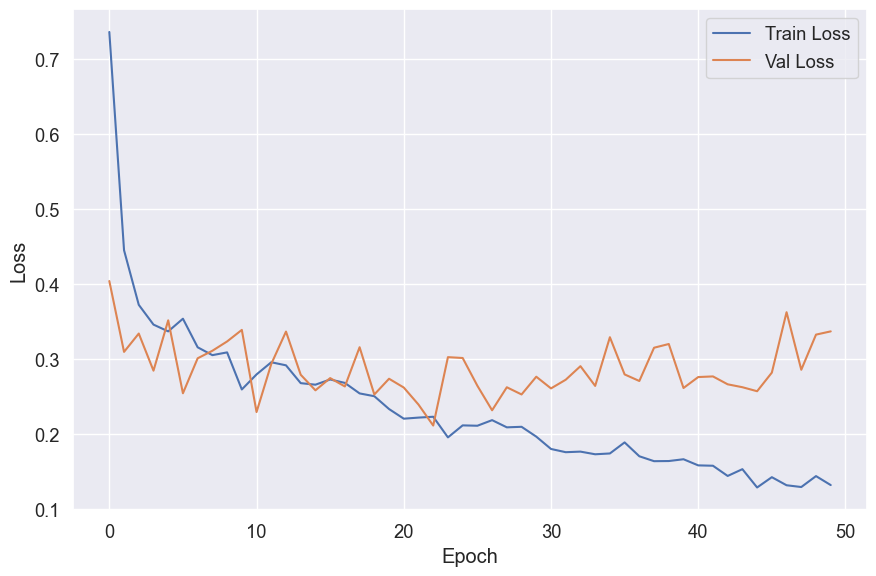

<Figure size 640x480 with 0 Axes>

In [27]:
# Convert tensors in the lists to numbers if necessary
train_losses_cpu = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses_cpu = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]

# Now plot these lists
plt.figure(figsize=(9, 6))
plt.plot(train_losses_cpu, label='Train Loss')
plt.plot(val_losses_cpu, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Save the plot
plt.savefig(f'{finetune_results_dir}/loss_plot.png')

### Save Results of all 3 Modell Saves: Best-Val-Accuracy, Best-Val-loss and full model


Evaluation Results:
Balanced Accuracy2: 92.25%
Test Accuracy: 92.58%

Evaluation Results:
Accuracy: 92.58%
Precision: 92.64%
Recall: 92.58%
F1-score: 92.60%
Kappa: 88.31%
                         precision    recall  f1-score   support

            [Kreischen]       0.92      0.93      0.93       220
[Kreischen][Quietschen]       0.88      0.90      0.89        71
              [Negativ]       0.96      0.93      0.94       167
           [Quietschen]       0.93      0.93      0.93        14

               accuracy                           0.93       472
              macro avg       0.92      0.92      0.92       472
           weighted avg       0.93      0.93      0.93       472



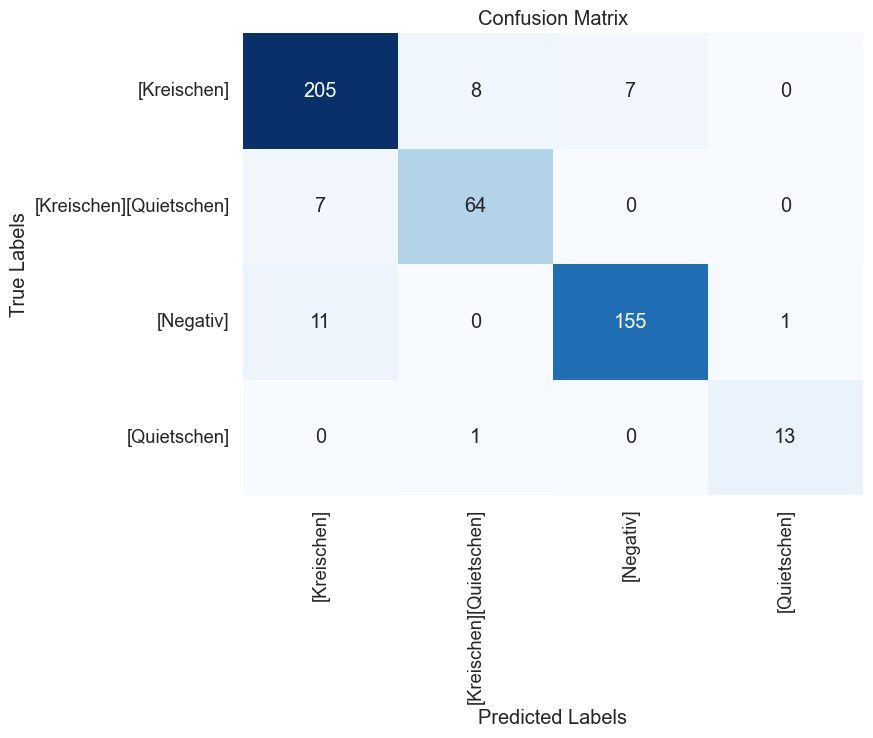

In [28]:

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support,balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score



# Set the device for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#config.val_sound_length = 20

# Create a data loader for the test set
val_loader = DL.create_generators_finetune_val(val_df)  


model = torch.load(finetune_results_dir + '/Full_model_checkpoint.pth')
# Transfer the model to the testing device
model.to(device)

# Define a criterion for evaluation 
criterion = nn.CrossEntropyLoss()

# Initialize variables for evaluation metrics (e.g., accuracy)
correct_predictions = 0
total_samples = 0

# Define the label dictionary
true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# Set the model to evaluation mode 
model.eval()

# Initialize lists to store all true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Iterate through the test set
with torch.no_grad():
    for spectrograms, labels in val_loader:
        # Move data to the testing device
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        
        # Compute the predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels to the lists
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
accuracy = np.mean(all_true_labels == all_predicted_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')


#calculate balanced accuracy
balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
#kappa score
cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


print(f"\nEvaluation Results:")
#print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")
print(f"Kappa: {cohens_kappa * 100:.2f}%")

conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
def plot_confusion_matrix(conf_mat, class_labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    
    class_labels = [str(label) for label in class_labels]
    
    ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)

    return plt.gcf()  # Return the current figure

#create classification results text file
with open(f'{finetune_results_dir}/results_file_full.txt', 'w') as log_file:
    log_file.write(f"########################################################\n")
    log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
    log_file.write(f"Time Mask: {config.time_mask_param}\n")
    log_file.write(f"Random State:{randomstate} \n")
    log_file.write(f"Spectro:\n")
    log_file.write(f"        n_fft={2048},\n")
    log_file.write(f"        hop_length = {512},\n")
    log_file.write(f"        n_mels={128},  \n")
    log_file.write(f"        win_length = {2048},\n")
    log_file.write(f"Epochs: {num_epochs}\n")
    log_file.write(f"Batch size: {batch_size}\n")
    log_file.write(f"Optimizer: Adam\n")
    log_file.write(f"Learning rate: {learning_rate}\n")
    log_file.write(f"Weight decay: {weight_decay}\n")
    log_file.write(f"Scheduler: ReduceLROnPlateau\n")
    log_file.write(f"Model: ModifiedResnet50_Classifier \n")
    log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
    log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
    log_file.write(f"\nEvaluation Results:\n")
    log_file.write(f"Precision: {precision * 100:.2f}%\n")
    log_file.write(f"Recall: {recall * 100:.2f}%\n")
    log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
    log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Confusion Matrix:\n")
    log_file.write(f"{conf_mat}\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values())}\n")

#save this plot as a png file
print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values()))

plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
plot.savefig(f'{finetune_results_dir}/confusion_matrix_full.png')










Evaluation Results:
Balanced Accuracy2: 91.07%
Test Accuracy: 93.43%

Evaluation Results:
Accuracy: 93.43%
Precision: 93.47%
Recall: 93.43%
F1-score: 93.43%
Kappa: 89.61%
                         precision    recall  f1-score   support

            [Kreischen]       0.92      0.95      0.94       220
[Kreischen][Quietschen]       0.90      0.90      0.90        71
              [Negativ]       0.96      0.93      0.95       167
           [Quietschen]       0.92      0.86      0.89        14

               accuracy                           0.93       472
              macro avg       0.93      0.91      0.92       472
           weighted avg       0.93      0.93      0.93       472



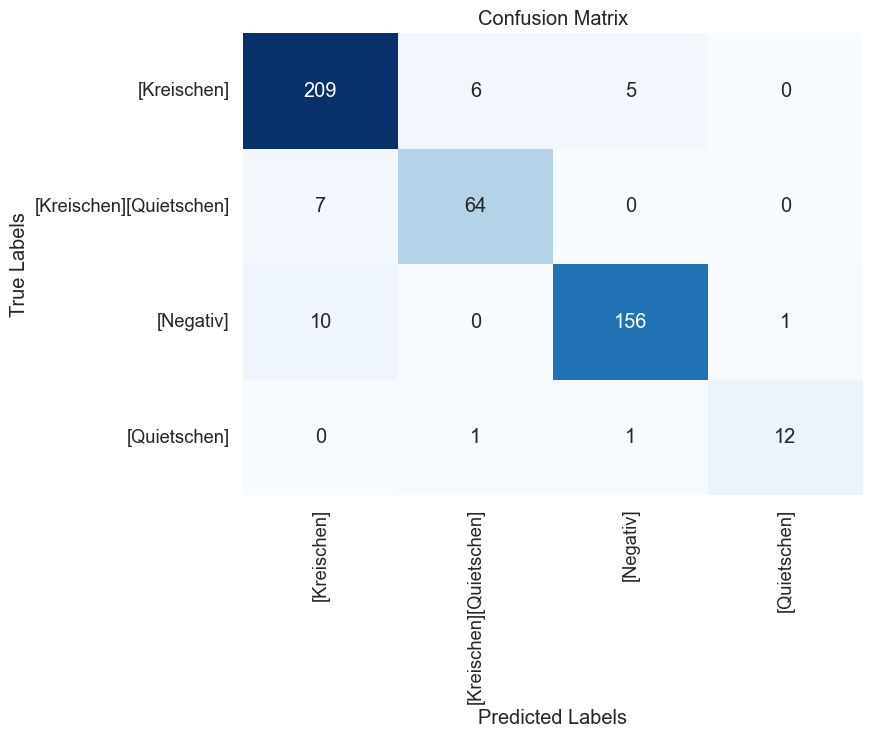

In [29]:

# Create a data loader for the test set
val_loader = DL.create_generators_finetune_val(val_df)  


model = torch.load(finetune_results_dir + '/checkpoint.pth')
#model = torch.load('./finetune_results/FT_ADSMI_120_epochs_2023-11-11-15/checkpoint.pth')
# Transfer the model to the testing device
model.to(device)

# Define a criterion for evaluation 
criterion = nn.CrossEntropyLoss()

# Initialize variables for evaluation metrics (e.g., accuracy)
correct_predictions = 0
total_samples = 0

# Define the label dictionary
true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# Set the model to evaluation mode 
model.eval()

# Initialize lists to store all true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Iterate through the test set
with torch.no_grad():
    for spectrograms, labels in val_loader:
        # Move data to the testing device
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        
        # Compute the predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels to the lists
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
accuracy = np.mean(all_true_labels == all_predicted_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')


#calculate balanced accuracy
balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
#kappa score
cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


print(f"\nEvaluation Results:")
#print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")
print(f"Kappa: {cohens_kappa * 100:.2f}%")

conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
def plot_confusion_matrix(conf_mat, class_labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    
    class_labels = [str(label) for label in class_labels]
    
    ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)

    return plt.gcf()  # Return the current figure

#create classification results text file
with open(f'{finetune_results_dir}/results_file_best.txt', 'w') as log_file:
    log_file.write(f"########################################################\n")
    log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
    log_file.write(f"Time Mask: {config.time_mask_param}\n")
    log_file.write(f"Random State:{randomstate} \n")
    log_file.write(f"Spectro:\n")
    log_file.write(f"        n_fft={2048},\n")
    log_file.write(f"        hop_length = {512},\n")
    log_file.write(f"        n_mels={128},  \n")
    log_file.write(f"        win_length = {2048},\n")
    log_file.write(f"Epochs: {num_epochs}\n")
    log_file.write(f"Batch size: {batch_size}\n")
    log_file.write(f"Optimizer: Adam\n")
    log_file.write(f"Learning rate: {learning_rate}\n")
    log_file.write(f"Weight decay: {weight_decay}\n")
    log_file.write(f"Scheduler: ReduceLROnPlateau\n")
    log_file.write(f"Model: ModifiedResnet50_Classifier \n")
    log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
    log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
    log_file.write(f"\nEvaluation Results:\n")
    log_file.write(f"Precision: {precision * 100:.2f}%\n")
    log_file.write(f"Recall: {recall * 100:.2f}%\n")
    log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
    log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Confusion Matrix:\n")
    log_file.write(f"{conf_mat}\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values())}\n")

print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values()))

#save this plot_confusion_matrix(conf_mat, true_labels_dic.values()) as a png file
plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
plot.savefig(f'{finetune_results_dir}/confusion_matrix_best.png')










Evaluation Results:
Balanced Accuracy2: 93.71%
Test Accuracy: 93.64%

Evaluation Results:
Accuracy: 93.64%
Precision: 93.72%
Recall: 93.64%
F1-score: 93.65%
Kappa: 90.02%
                         precision    recall  f1-score   support

            [Kreischen]       0.95      0.92      0.94       220
[Kreischen][Quietschen]       0.91      0.94      0.92        71
              [Negativ]       0.92      0.96      0.94       167
           [Quietschen]       1.00      0.93      0.96        14

               accuracy                           0.94       472
              macro avg       0.95      0.94      0.94       472
           weighted avg       0.94      0.94      0.94       472



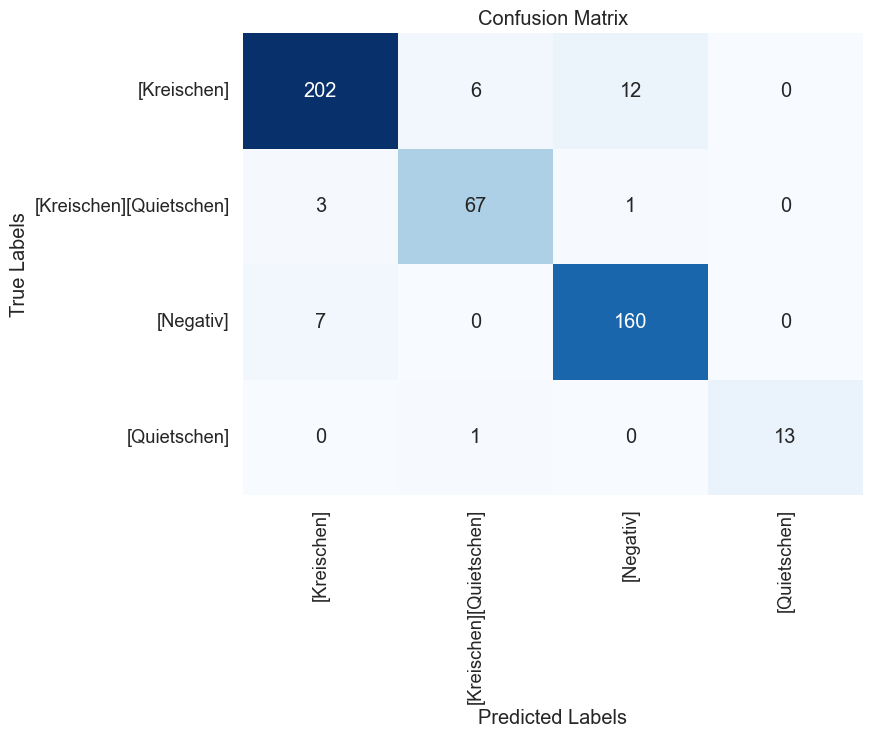

: 

In [30]:

# Create a data loader for the test set
val_loader = DL.create_generators_finetune_val(val_df)  


model = torch.load(finetune_results_dir + '/checkpoint_best_loss.pth')
#model = torch.load('./finetune_results/FT_ADSMI_120_epochs_2023-11-11-15/checkpoint.pth')
# Transfer the model to the testing device
model.to(device)

# Define a criterion for evaluation 
criterion = nn.CrossEntropyLoss()

# Initialize variables for evaluation metrics 
correct_predictions = 0
total_samples = 0

# Define the label dictionary
true_labels_dic = {0: '[Kreischen]', 1: '[Kreischen][Quietschen]', 2: '[Negativ]', 3: '[Quietschen]'}

# Set the model to evaluation mode 
model.eval()

# Initialize lists to store all true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Iterate through the test set
with torch.no_grad():
    for spectrograms, labels in val_loader:
        # Move data to the testing device
        spectrograms = spectrograms.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(spectrograms)
        
        # Compute the predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels to the lists
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)

# Calculate accuracy, precision, recall, F1-score, etc. using all_true_labels and all_predicted_labels
accuracy = np.mean(all_true_labels == all_predicted_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_true_labels, all_predicted_labels, average='weighted')


#calculate balanced accuracy
balanced_accuracy2 = balanced_accuracy_score(all_true_labels, all_predicted_labels)
#kappa score
cohens_kappa = cohen_kappa_score(all_true_labels, all_predicted_labels)


print(f"\nEvaluation Results:")
#print(f"Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
print(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%")

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"\nEvaluation Results:")
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-score: {f1_score * 100:.2f}%")
print(f"Kappa: {cohens_kappa * 100:.2f}%")

conf_mat = confusion_matrix(all_true_labels, all_predicted_labels)
def plot_confusion_matrix(conf_mat, class_labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    
    class_labels = [str(label) for label in class_labels]
    
    ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels)
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=90)

    return plt.gcf()  # Return the current figure

#create classification results text file
with open(f'{finetune_results_dir}/results_file_best_loss.txt', 'w') as log_file:
    log_file.write(f"########################################################\n")
    log_file.write(f"Frequency Mask:{config.freq_mask_param}\n")
    log_file.write(f"Time Mask: {config.time_mask_param}\n")
    log_file.write(f"Random State:{randomstate} \n")
    log_file.write(f"Spectro:\n")
    log_file.write(f"        n_fft={2048},\n")
    log_file.write(f"        hop_length = {512},\n")
    log_file.write(f"        n_mels={128},  \n")
    log_file.write(f"        win_length = {2048},\n")
    log_file.write(f"Epochs: {num_epochs}\n")
    log_file.write(f"Batch size: {batch_size}\n")
    log_file.write(f"Optimizer: Adam\n")
    log_file.write(f"Learning rate: {learning_rate}\n")
    log_file.write(f"Weight decay: {weight_decay}\n")
    log_file.write(f"Scheduler: ReduceLROnPlateau\n")
    log_file.write(f"Model: ModifiedResnet50_Classifier \n")
    log_file.write(f"classifiers: 512, 256, 4 : 2 fully connected layers\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Balanced Accuracy2: {balanced_accuracy2 * 100:.2f}%\n")
    log_file.write(f"Test Accuracy: {accuracy * 100:.2f}%\n")
    log_file.write(f"\nEvaluation Results:\n")
    log_file.write(f"Precision: {precision * 100:.2f}%\n")
    log_file.write(f"Recall: {recall * 100:.2f}%\n")
    log_file.write(f"F1-score: {f1_score * 100:.2f}%\n")
    log_file.write(f"Kappa: {cohens_kappa * 100:.2f}%\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Confusion Matrix:\n")
    log_file.write(f"{conf_mat}\n")
    log_file.write(f"########################################################\n\n")
    log_file.write(f"Classifcation Report: {classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values())}\n")

print(classification_report(all_true_labels, all_predicted_labels, target_names=true_labels_dic.values()))

#save this plot_confusion_matrix(conf_mat, true_labels_dic.values()) as a png file
plot = plot_confusion_matrix(conf_mat, true_labels_dic.values())
plot.savefig(f'{finetune_results_dir}/confusion_matrix_best_loss.png')







